In [1]:
from oda_api.api import DispatcherAPI
from oda_api.plot_tools import OdaImage,OdaLightCurve
from oda_api.data_products import BinaryData
import os
from astropy.io import fits
import numpy as np
from numpy import sqrt,exp
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
source_name='Crab'
ra=83.633080
dec=22.014500
radius=15.
radius_jemx=5.
Tstart='2003-03-16T00:00:00'
Tstop='2015-03-15T23:59:59'
host='https://www.astro.unige.ch/cdci/astrooda/dispatch-data'
E1_keV=20.
E2_keV=40.
E1_keV_jemx=3.
E2_keV_jemx=20.

rebin=10

In [3]:
disp=DispatcherAPI(host=host)

In [13]:
data=disp.get_product(instrument='isgri',
                      product='isgri_image',
                      T1=Tstart,
                      T2=Tstop,
                      E1_keV=E1_keV,
                      E2_keV=E2_keV,
                      osa_version='OSA10.2',
                      RA=ra,
                      DEC=dec,
                      detection_threshold=10,
                      product_type='Real')

- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2003-03-16T00:00:00
T2 2015-03-15T23:59:59
E1_keV 20.0
E2_keV 40.0
osa_version OSA10.2
RA 83.63308
DEC 22.0145
detection_threshold 10
instrument isgri
product_type isgri_image
query_type Real
off_line (False,)
query_status ('new',)
verbose (False,)
session_id 0SECVI92W7T5V7HK
dry_run (False,)
api True
the job has been submitted on the remote server
 / the job is working remotely, please wait status=done - job_id=7876165725006684297  97  

query done succesfully!


In [14]:
data.dispatcher_catalog_1.table

meta_ID,src_names,significance,ra,dec,NEW_SOURCE,ISGRI_FLAG,FLAG,ERR_RAD
,,,deg,deg,,,,
int64,str11,float64,float64,float64,int64,int64,int64,object
0,1A 0535+262,275.7215881347656,84.72891998291016,26.31559181213379,-32768,2,0,0.0002800000074785203
5,Crab,1519.4791259765625,83.63150024414062,22.016033172607422,-32768,2,0,0.0002800000074785203
23,NEW_1,11.129651069641113,82.82781219482422,32.581546783447266,-32767,0,0,None
46,Crab,218.60061645507812,83.63021850585938,22.015247344970703,-32768,2,0,0.0002800000074785203


In [15]:
torm=[2,3]
data.dispatcher_catalog_1.table.remove_rows(torm)


In [16]:
api_cat=data.dispatcher_catalog_1.get_api_dictionary()

In [18]:
spectrum_isgri=disp.get_product(instrument='isgri',
                    product='isgri_spectrum',
                    T1=Tstart,
                    T2=Tstop,
                    query_type='Real',
                    osa_version='OSA10.2',
                    RA=ra,
                    DEC=dec,
                    product_type='Real',
                    selected_catalog=api_cat)


- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2003-03-16T00:00:00
T2 2015-03-15T23:59:59
query_type Real
osa_version OSA10.2
RA 83.63308
DEC 22.0145
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[0, 5], ["1A 0535+262", "Crab"], [275.7215881347656, 1519.4791259765625], [84.72891998291016, 83.63150024414062], [26.31559181213379, 22.016033172607422], [-32768, -32768], [2, 2], [0, 0], [0.0002800000074785203, 0.0002800000074785203]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", "dec", "NEW_SOURCE", "ISGRI_FLAG", "FLAG", "ERR_RAD"], "cat_column_descr": [["meta_ID", "<i8"], ["src_names", "<U11"], ["significance", "<f8"], ["ra", "<f8"], ["dec", "<f8"], ["NEW_SOURCE", "<i8"], ["ISGRI_FLAG", "<i8"], ["FLAG", "<i8"], ["ERR_RAD", "|O"]], "cat_lat_name": "dec", "cat_lon_name": "ra"}
instrument isgri
product_type isgri_spectrum
off_line (False,)
query_status ('new',)
verbos

In [19]:
FLAG=0
for ID,s in enumerate(spectrum_isgri._p_list):
    if (s.meta_data['src_name']==source_name):
        if(s.meta_data['product']=='isgri_spectrum')and(FLAG==0):
            ID_spec=ID
            FLAG=1
            ID_arf=ID+1
            ID_rmf=ID+2

print(ID_spec, ID_arf, ID_rmf)


3 4 5


In [20]:
name=source_name.replace(" ", "")
specname=name+'_spectrum_osa10.fits'
arfname=name+'_arf_osa10.fits.gz'
rmfname=name+'_rmf_osa10.fits.gz'
spectrum_isgri._p_list[ID_spec].write_fits_file(specname)
spectrum_isgri._p_list[ID_arf].write_fits_file(arfname)
spectrum_isgri._p_list[ID_rmf].write_fits_file(rmfname)


In [21]:
expos=spectrum_isgri._p_list[0].data_unit[1].header['EXPOSURE']
hdul = fits.open(specname, mode='update')
hdr=hdul[1].header
hdr.set('EXPOSURE', expos)
hdul.close()

In [28]:
rebin=10
!./spectrum_fit_bknpower.sh $name $rebin


		XSPEC version: 12.10.1f
	Build Date/Time: Fri Oct  4 00:41:04 2019

XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.
XSPEC12>data Crab_spectrum_osa10.fits
***Warning: POISSERR keyword is missing or of wrong format, assuming FALSE.

1 spectrum  in use
 
Spectral Data File: Crab_spectrum_osa10.fits  Spectrum 1
Net count rate (cts/s) for Spectrum:1  nan       +/- nan      
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-62
  Telescope: INTEGRAL Instrument: IBIS  Channel Type: PI
  Exposure Time: 7.582e+04 sec
 Using fit statistic: chi
 Using test statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
XSPEC12>response Crab_rmf_osa10.fits.gz
Response successfully loaded.
XSPEC12>arf Crab_arf_osa10.fits.gz
Arf successfully loaded.
XSPEC12>ignore bad

ignore:     1 channels ignored from  source number 1
XSPEC12>ig

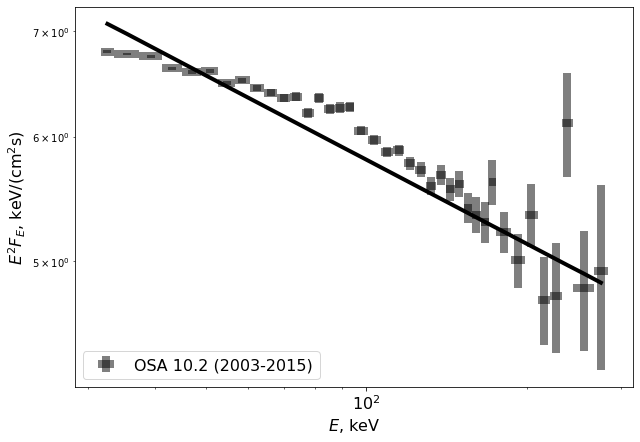

In [26]:
plt.figure(figsize=(10,7))

spectrum=np.genfromtxt(name+'_spectrum_osa10.txt',skip_header=3)
en=spectrum[:,0]
en_err=spectrum[:,1]
fl=spectrum[:,2]
fl_err=spectrum[:,3]
mo=spectrum[:,4]
plt.errorbar(en,fl,xerr=en_err,yerr=fl_err,linestyle='none',linewidth=8,color='black',alpha=0.5,label='OSA 10.2 (2003-2015)')
plt.plot(en,mo,color='black',linewidth=4)


plt.tick_params(axis='both', which='major', labelsize=16)
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1.e-3,6.e-1)
#plt.xlim(15,350)
plt.xlabel('$E$, keV',fontsize=16)
plt.ylabel('$E^2F_E$, keV/(cm$^2$s)',fontsize=16)
plt.legend(loc='lower left',fontsize=16)
plt.savefig(name+'_spectrum.pdf',format='pdf',dpi=100)
